In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2.2.3 데이터 증강을 이용해 개와 고양이 이미지 분류하기

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import get_file
import os

train_url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

def get_data(fname, origin, extract):
    data_dir = get_file(fname=fname, 
                        origin=origin, 
                        extract=extract,
                        cache_subdir='/content/drive/MyDrive/Colab Notebooks/data')
    data_dir = os.path.join(os.path.dirname(data_dir), 'cats_and_dogs_filtered')
    return data_dir

path_dir = get_data('train.zip', train_url, 'True')

train_dir = os.path.join(path_dir, 'train')
validation_dir = os.path.join(path_dir, 'validation')

print('\n', train_dir)
print(validation_dir)


 /content/drive/MyDrive/Colab Notebooks/data/cats_and_dogs_filtered/train
/content/drive/MyDrive/Colab Notebooks/data/cats_and_dogs_filtered/validation


In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds = image_dataset_from_directory(
  directory=train_dir,
  batch_size=32,# Default: 32
  image_size=(256, 256),# Defaults: (256, 256)
  shuffle=True,# Default: True
  seed=0)

validation_ds = image_dataset_from_directory(
  directory=validation_dir,
  batch_size=32,# Default: 32
  image_size=(256, 256),# Defaults: (256, 256)
  shuffle=True,# Default: True
  seed=0)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
for data, labels in train_ds.take(1):
    print(data.shape)
    print(labels.shape) 

(32, 256, 256, 3)
(32,)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

data_augmentation = Sequential(
  [
      RandomFlip("horizontal_and_vertical", input_shape=(256, 256, 3)),
      RandomRotation(0.3),
  ]
)

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
validation_ds = validation_ds.prefetch(buffer_size=32)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dense

model = Sequential([
  data_augmentation,
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  
  Flatten(),
  Dense(128, activation='relu'),
  Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=["accuracy"]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                                 
 dense (Dense)               (None, 128)               33554560  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                      

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

callback_EarlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callback_ModelCheckpoint = ModelCheckpoint(filepath='./ModelCheckpoint',
                           monitor='val_loss',
                           save_weights_only=True,
                           save_best_only=True,
                           verbose=1)

In [ ]:
%%time

history = model.fit(train_ds,
  validation_data=validation_ds,
  epochs=100,
  callbacks=[callback_EarlyStopping, callback_ModelCheckpoint]
)

Epoch 1/100


63/63 [==============================] - ETA: 0s - loss: 459.9690 - accuracy: 0.5085
Epoch 1: val_loss improved from inf to 43.21309, saving model to ./ModelCheckpoint
63/63 [==============================] - 26s 296ms/step - loss: 459.9690 - accuracy: 0.5085 - val_loss: 43.2131 - val_accuracy: 0.5060
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 20.0182 - accuracy: 0.5265
Epoch 2: val_loss did not improve from 43.21309
63/63 [==============================] - 12s 187ms/step - loss: 20.0182 - accuracy: 0.5265 - val_loss: 196.6462 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 15.5070 - accuracy: 0.5475
Epoch 3: val_loss improved from 43.21309 to 6.10299, saving model to ./ModelCheckpoint
63/63 [==============================] - 14s 208ms/step - loss: 15.5070 - accuracy: 0.5475 - val_loss: 6.1030 - val_accuracy: 0.5400
Epoch 4/100
63/63 [==============================] - ETA: 0s - loss: 10.6224 - accuracy: 0.5700
Epoch 

In [ ]:
#from keras.preprocessing.image import load_img
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array

img_path = '/content/drive/MyDrive/Colab Notebooks/data/cats_and_dogs_filtered/validation/cats/cat.2008.jpg'

img = load_img(img_path, target_size=(256, 256))
img_array = tf.expand_dims(img_to_array(img), 0)

predictions = model.predict(img_array)

print('cat', 100 * (1 - predictions[0]))
print('dog', 100 * predictions[0])

1/1 [==============================] - 0s 110ms/step
cat [50.308098]
dog [49.691906]


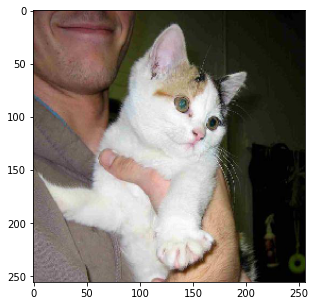

In [ ]:
import matplotlib.pyplot as plt
img_array /= 255.

plt.figure(figsize=(5, 5))
plt.imshow(img_array[0])
plt.show()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(specs=[[{"secondary_y": True}]])

# model history
epoch = history.epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Scatter
fig.add_trace(go.Scatter(x=epoch, y=loss, name="loss"),secondary_y=False,)
fig.add_trace(go.Scatter(x=epoch, y=val_loss, name="val_loss"),secondary_y=False,)
fig.add_trace(go.Scatter(x=epoch, y=accuracy, name="accuracy"),secondary_y=True,)
fig.add_trace(go.Scatter(x=epoch, y=val_accuracy, name="val_accuracy"),secondary_y=True,)

# Templates configuration, Default template: 'plotly'
# Available templates: ['ggplot2', 'seaborn', 'simple_white', 'plotly','plotly_white', 'plotly_dark', 'presentation', 'xgridoff','ygridoff', 'gridon', 'none']
fig.update_layout(title_text="<b>Loss/Accuracy of Model</b>", template='plotly')

fig.update_xaxes(title_text="Epoch")
fig.update_yaxes(title_text="Loss", secondary_y=False)
fig.update_yaxes(title_text="Accuracy", secondary_y=True)

fig.show()
